<a href="https://colab.research.google.com/github/anikaemo/1streposi/blob/main/Copy_of_Liver_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports Libraies

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, joblib, os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shap
!pip install lime
from lime.lime_tabular import LimeTabularExplainer
!pip install optuna
import optuna
pd.set_option('display.max_columns',200)
sns.set_style('whitegrid')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4409c865046398fc8bc052eda01929090d94e56914c6ef639314fcb649843a36
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.4 MB/s eta 0:00:00


Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Corrected mountpoint to a directory
import os

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/Liver Patient Dataset (LPD)_train.csv', encoding='latin1')
df.head()

Age of the patient Gender of the patient  Total Bilirubin  \
0                65.0                Female              0.7   
1                62.0                  Male             10.9   
2                62.0                  Male              7.3   
3                58.0                  Male              1.0   
4                72.0                  Male              3.9   

   Direct Bilirubin   Alkphos Alkaline Phosphotase  \
0               0.1                          187.0   
1               5.5                          699.0   
2               4.1                          490.0   
3               0.4                          182.0   
4               2.0                          195.0   

    Sgpt Alamine Aminotransferase  Sgot Aspartate Aminotransferase  \
0                            16.0                             18.0   
1                            64.0                            100.0   
2                            60.0                             68.0   
3                            14.0                             20.0   
4                            27.0                             59.0   

   Total Protiens   ALB Albumin  A/G Ratio Albumin and Globulin Ratio  Result  
0             6.8           3.3                                  0.90       1  
1             7.5           3.2                                  0.74       1  
2             7.0           3.3                                  0.89       1  
3             6.8           3.4                                  1.00       1  
4             7.3           2.4                                  0.40       1

Basic EDA

In [ ]:
df.head(5)

Age of the patient Gender of the patient  Total Bilirubin  \
0                65.0                Female              0.7   
1                62.0                  Male             10.9   
2                62.0                  Male              7.3   
3                58.0                  Male              1.0   
4                72.0                  Male              3.9   

   Direct Bilirubin   Alkphos Alkaline Phosphotase  \
0               0.1                          187.0   
1               5.5                          699.0   
2               4.1                          490.0   
3               0.4                          182.0   
4               2.0                          195.0   

    Sgpt Alamine Aminotransferase  Sgot Aspartate Aminotransferase  \
0                            16.0                             18.0   
1                            64.0                            100.0   
2                            60.0                             68.0   
3                            14.0                             20.0   
4                            27.0                             59.0   

   Total Protiens   ALB Albumin  A/G Ratio Albumin and Globulin Ratio  Result  
0             6.8           3.3                                  0.90       1  
1             7.5           3.2                                  0.74       1  
2             7.0           3.3                                  0.89       1  
3             6.8           3.4                                  1.00       1  
4             7.3           2.4                                  0.40       1

In [ ]:
df.tail(5)

Age of the patient Gender of the patient  Total Bilirubin  \
30686                50.0                  Male              2.2   
30687                55.0                  Male              2.9   
30688                54.0                  Male              6.8   
30689                48.0                Female              1.9   
30690                30.0                  Male              3.1   

       Direct Bilirubin   Alkphos Alkaline Phosphotase  \
30686               1.0                          610.0   
30687               1.3                          482.0   
30688               3.0                          542.0   
30689               1.0                          231.0   
30690               1.6                          253.0   

        Sgpt Alamine Aminotransferase  Sgot Aspartate Aminotransferase  \
30686                            17.0                             28.0   
30687                            22.0                             34.0   
30688                           116.0                             66.0   
30689                            16.0                             55.0   
30690                            80.0                            406.0   

       Total Protiens   ALB Albumin  A/G Ratio Albumin and Globulin Ratio  \
30686             7.3           2.6                                  0.55   
30687             7.0           2.4                                  0.50   
30688             6.4           3.1                                  0.90   
30689             4.3           1.6                                  0.60   
30690             6.8           3.9                                  1.30   

       Result  
30686       1  
30687       1  
30688       1  
30689       1  
30690       1

In [ ]:
df.duplicated().sum()

np.int64(11323)

In [ ]:
df.isnull().sum()

Age of the patient                        2
Gender of the patient                   902
Total Bilirubin                         648
Direct Bilirubin                        561
 Alkphos Alkaline Phosphotase           796
 Sgpt Alamine Aminotransferase          538
Sgot Aspartate Aminotransferase         462
Total Protiens                          463
 ALB Albumin                            494
A/G Ratio Albumin and Globulin Ratio    559
Result                                    0
dtype: int64

In [ ]:
df.shape

(30691, 11)

Missing Value Handling

In [ ]:
x = df.drop(columns=['Result'],axis=1)

In [ ]:
df.rename(columns={'Result\t': 'Result'}, inplace=True)


Number of Samples Dataset

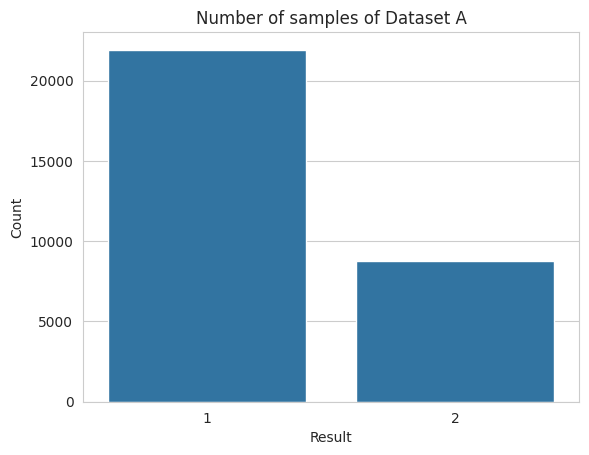

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Result', data=df)
plt.title('Number of samples of Dataset A')
plt.xlabel('Result')
plt.ylabel('Count')
plt.savefig('Number of samples of Dataset A.pdf', bbox_inches='tight')
plt.show()

Data Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Clean column names first: remove leading/trailing whitespace, non-breaking spaces (\xa0), and tabs (\t)
df.columns = df.columns.str.strip().str.replace('\xa0', '').str.replace('\t', '')

# Apply one-hot encoding only to the 'Gender of the patient' column,
# as other columns appear to be numerical or the target variable.
df_encoded = pd.get_dummies(df, columns=['Gender of the patient'], drop_first=True)

# Display the head of the new df_encoded to confirm the changes
df_encoded.head()

Age of the patient  Total Bilirubin  Direct Bilirubin  \
0                65.0              0.7               0.1   
1                62.0             10.9               5.5   
2                62.0              7.3               4.1   
3                58.0              1.0               0.4   
4                72.0              3.9               2.0   

   Alkphos Alkaline Phosphotase  Sgpt Alamine Aminotransferase  \
0                         187.0                           16.0   
1                         699.0                           64.0   
2                         490.0                           60.0   
3                         182.0                           14.0   
4                         195.0                           27.0   

   Sgot Aspartate Aminotransferase  Total Protiens  ALB Albumin  \
0                             18.0             6.8          3.3   
1                            100.0             7.5          3.2   
2                             68.0             7.0          3.3   
3                             20.0             6.8          3.4   
4                             59.0             7.3          2.4   

   A/G Ratio Albumin and Globulin Ratio  Result  Gender of the patient_Male  
0                                  0.90       1                       False  
1                                  0.74       1                        True  
2                                  0.89       1                        True  
3                                  1.00       1                        True  
4                                  0.40       1                        True

In [ ]:
# Convert 'bool' columns to int (True -> 1, False -> 0)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Convert 'object' columns to numeric using Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
object_cols = df.select_dtypes(include='object').columns

for col in object_cols:
    df[col] = df[col].astype(str)  # Ensure all values are strings
    df[col] = label_encoder.fit_transform(df[col])

# Check the result
print(df.head())
print(df.dtypes)

   Age of the patient  Gender of the patient  Total Bilirubin  \
0                65.0                      0              0.7   
1                62.0                      1             10.9   
2                62.0                      1              7.3   
3                58.0                      1              1.0   
4                72.0                      1              3.9   

   Direct Bilirubin  Alkphos Alkaline Phosphotase  \
0               0.1                         187.0   
1               5.5                         699.0   
2               4.1                         490.0   
3               0.4                         182.0   
4               2.0                         195.0   

   Sgpt Alamine Aminotransferase  Sgot Aspartate Aminotransferase  \
0                           16.0                             18.0   
1                           64.0                            100.0   
2                           60.0                             68.0   
3             

In [ ]:
df.value_counts('Result')

Result
1    21917
2     8774
Name: count, dtype: int64

In [ ]:
df.head()

Age of the patient  Gender of the patient  Total Bilirubin  \
0                65.0                      0              0.7   
1                62.0                      1             10.9   
2                62.0                      1              7.3   
3                58.0                      1              1.0   
4                72.0                      1              3.9   

   Direct Bilirubin  Alkphos Alkaline Phosphotase  \
0               0.1                         187.0   
1               5.5                         699.0   
2               4.1                         490.0   
3               0.4                         182.0   
4               2.0                         195.0   

   Sgpt Alamine Aminotransferase  Sgot Aspartate Aminotransferase  \
0                           16.0                             18.0   
1                           64.0                            100.0   
2                           60.0                             68.0   
3                           14.0                             20.0   
4                           27.0                             59.0   

   Total Protiens  ALB Albumin  A/G Ratio Albumin and Globulin Ratio  Result  
0             6.8          3.3                                  0.90       1  
1             7.5          3.2                                  0.74       1  
2             7.0          3.3                                  0.89       1  
3             6.8          3.4                                  1.00       1  
4             7.3          2.4                                  0.40       1

Data Smote

In [ ]:
num_cols = df.shape[1]

print("Number of columns:", num_cols)

Number of columns: 11


In [ ]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
#check unique value for each variable
for col in df.columns:
    unique_values = df[col].unique()
    print(f"Unique values for {col}: {unique_values}")

Unique values for Age of the patient: [65. 62. 58. 72. 46. 26. 29. 17. 55. 57. 64. 74. 61. 25. 38. 33. 40. 51.
 63. 34. 20. 84. 52. 30. 48. 47. 45. 42. 50. 85. 35. 21. 32. 31. 54. 37.
 66. 60. 19. 75. 68. 70. 49. 14. 13. 18. 39. 27. 36. 24. 28. 53. 15. 56.
 44. 41.  7. 22.  8.  6.  4. 43. 23. 12. 69. 16. 78. 11. 73. 67. 10. 90.
 77. 80. nan 89. 86. 83.]
Unique values for Gender of the patient: [0 1 2]
Unique values for Total Bilirubin: [ 0.7 10.9  7.3  1.   3.9  1.8  0.9  0.6  2.7  1.1  1.6  2.2  2.9  nan
  1.9  4.1  6.2  4.   2.6  1.3 14.2  1.4  2.4  6.8 18.4  3.1  8.9  0.8
  2.8  2.   5.7  8.6  5.8  5.2  3.8  6.6  0.5  5.3  3.2  1.2 12.7 15.9
 18.  23.  22.7  3.   1.7 11.3  4.7  4.2  3.5  5.9  8.7 11.  11.5  4.5
 75.  22.8 14.1 14.8 10.6  8.   1.5  2.1  6.3  2.3 27.2  2.5  3.6 30.5
 16.4 14.5 18.5 23.2  3.7  3.3  7.1  6.7 22.6  7.5  5.   4.9  8.2  0.4
  7.4 23.3  7.9  3.4 19.8 32.6 17.7 20.  26.3  4.4  9.4 30.8 19.6 15.8
  5.5 20.2 27.7 11.1 10.2 42.8 15.2 16.6 17.3 22.5 16.7  7.7 15

Age of the patient
Skew : 0.03


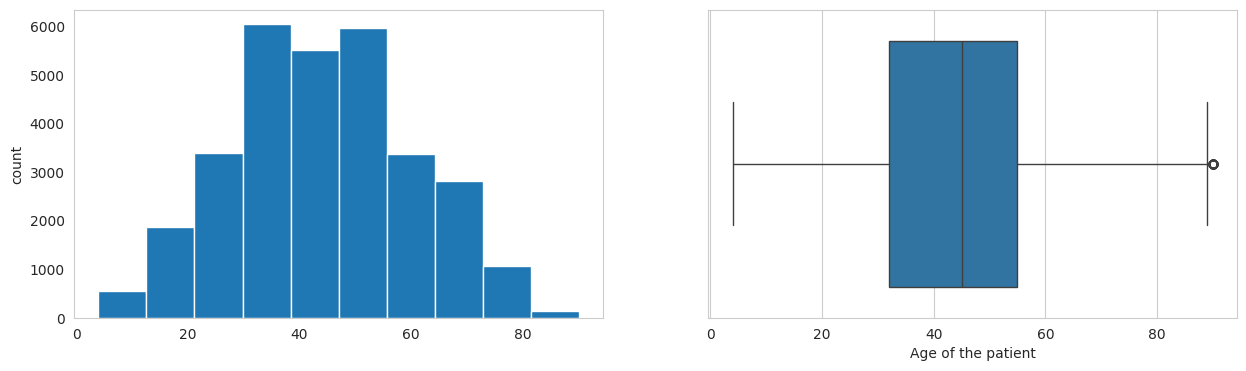

Gender of the patient
Skew : -0.5


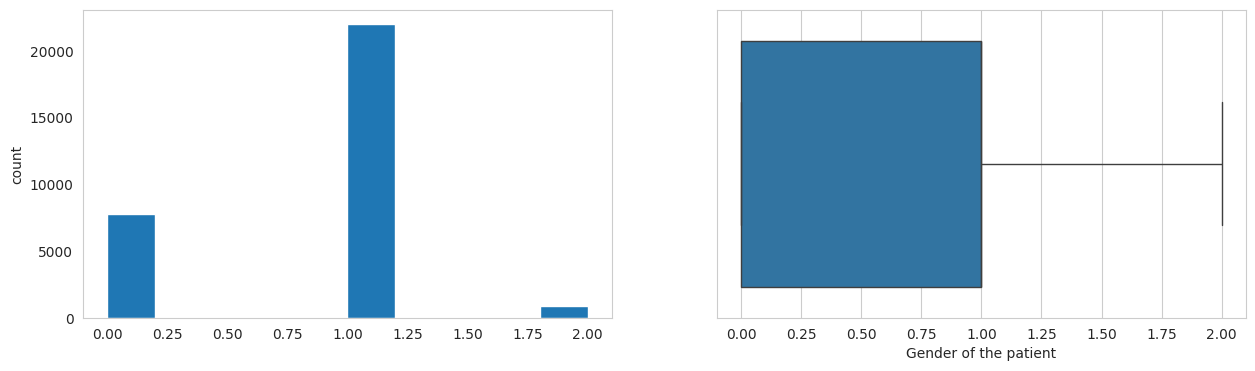

Total Bilirubin
Skew : 4.66


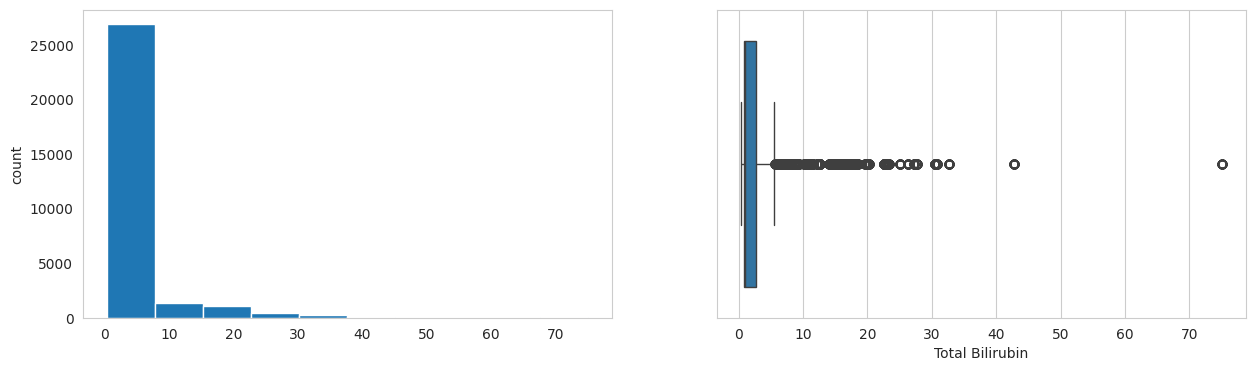

Direct Bilirubin
Skew : 3.16


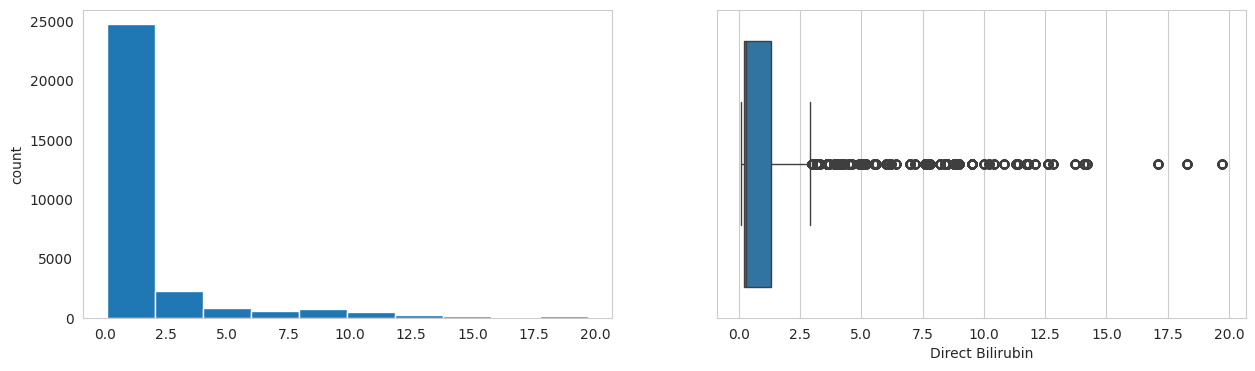

Alkphos Alkaline Phosphotase
Skew : 3.78


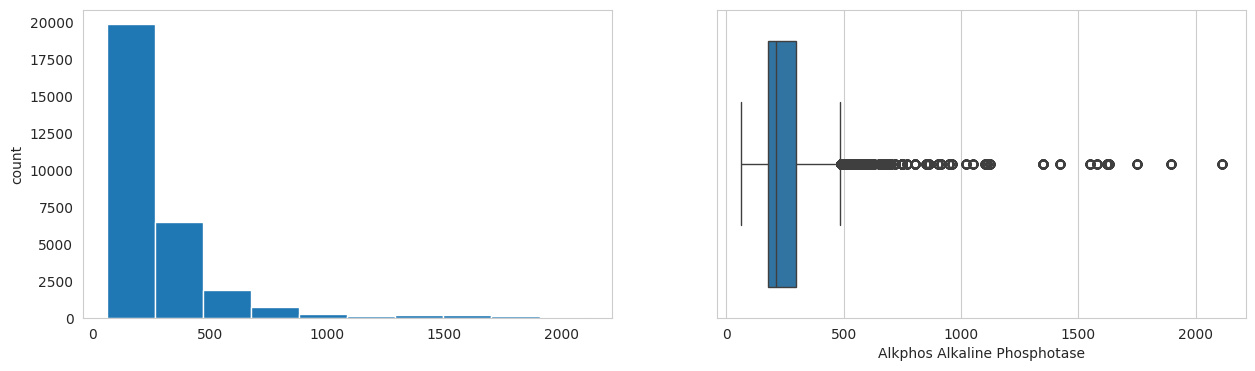

Sgpt Alamine Aminotransferase
Skew : 6.46


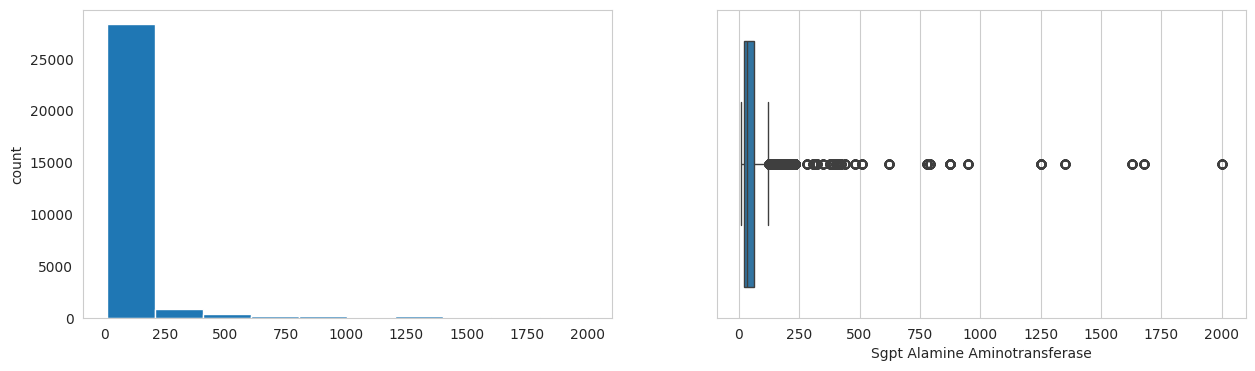

Sgot Aspartate Aminotransferase
Skew : 10.34


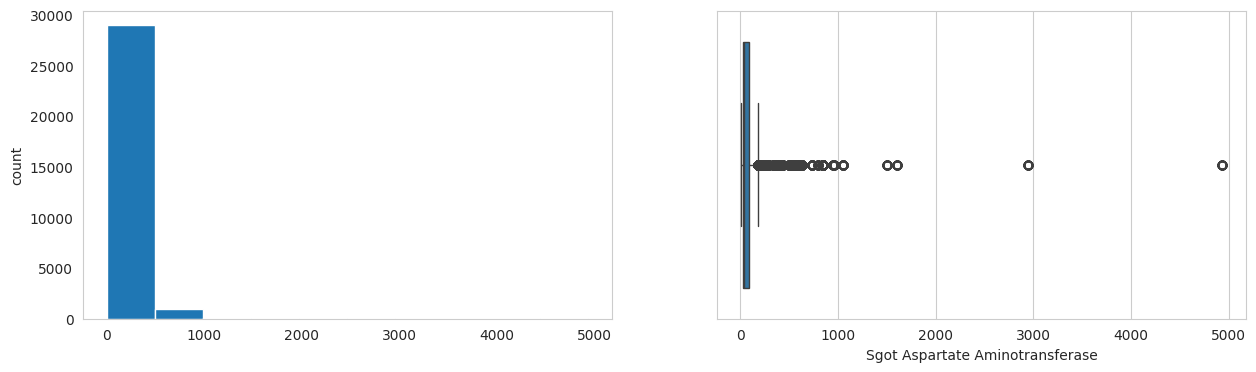

Total Protiens
Skew : -0.29


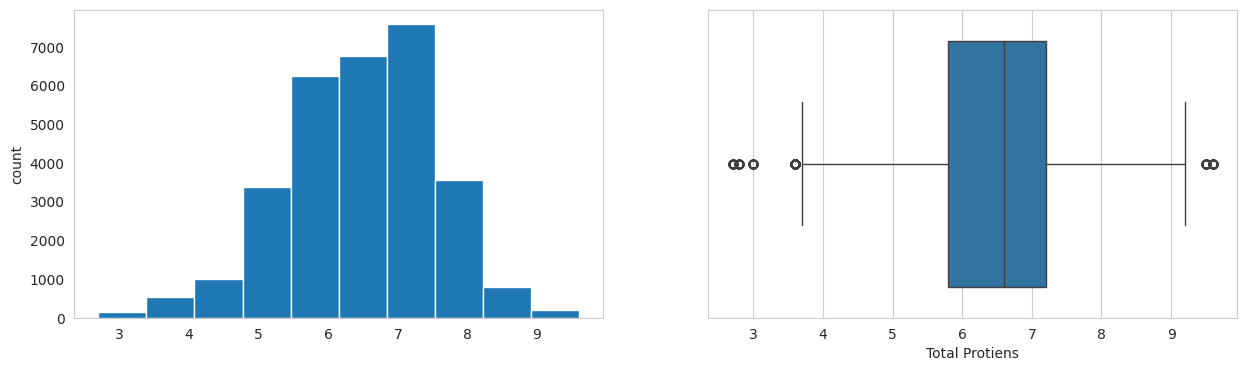

ALB Albumin
Skew : -0.04


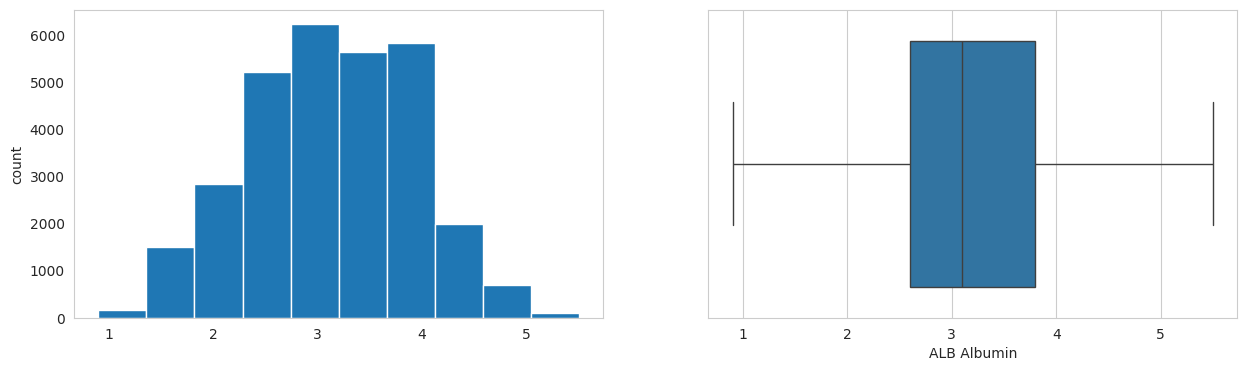

A/G Ratio Albumin and Globulin Ratio
Skew : 1.06


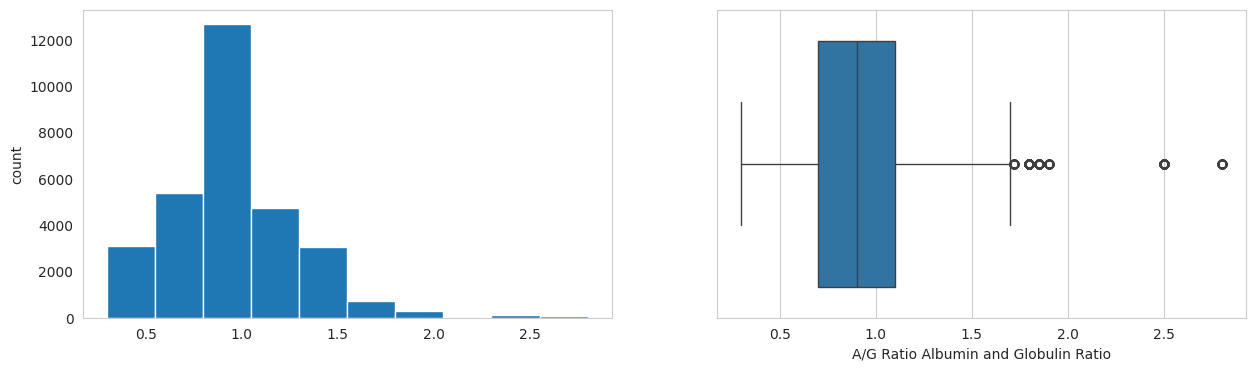

Result
Skew : 0.95


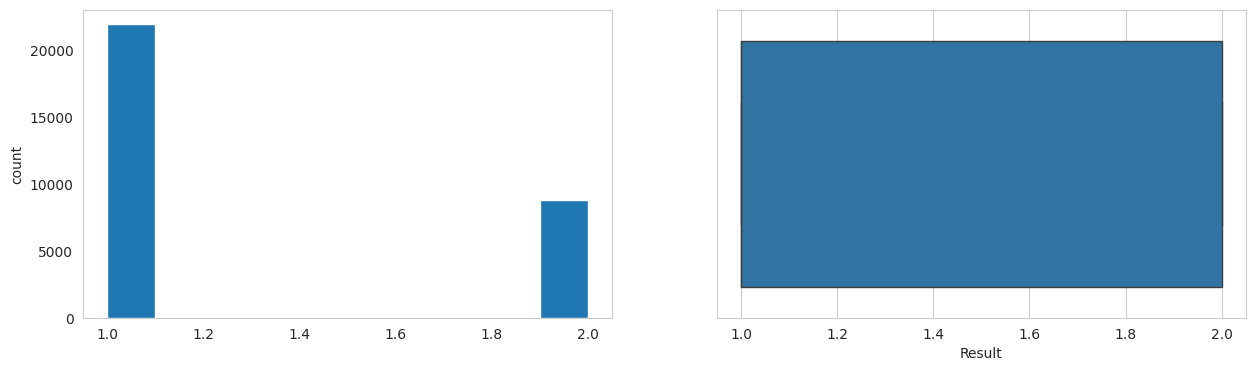

In [ ]:
import seaborn as sns
for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

In [ ]:
x = df.drop(columns=['Result'])
y = df['Result'] - 1 # Adjusting the target variable to be 0 and 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)

In [ ]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

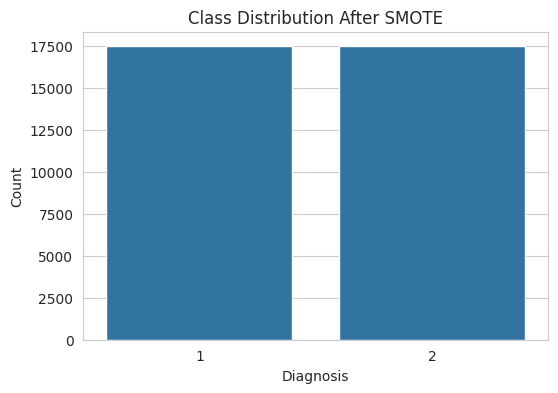

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Visualize the balanced dataset
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

Auto clinical feature engineering

In [ ]:
# create clinical features if columns exist
cols = {c.lower():c for c in df.columns}
def c(n): return cols.get(n.lower())

created=[]
if c('ast') and c('alt'):
    df['AST_ALT_ratio'] = df[c('ast')] / (df[c('alt')] + 1e-9); created.append('AST_ALT_ratio')
if c('ast') and c('platelets') or c('platelet_count'):
    plat = c('platelets') or c('platelet_count')
    ULN_AST = 40.0
    df['APRI'] = (df[c('ast')] / ULN_AST) / (df[plat] + 1e-9) * 100; created.append('APRI')
if c('age') and c('ast') and c('alt') and (c('platelets') or c('platelet_count')):
    plat = c('platelets') or c('platelet_count')
    df['FIB4'] = (df[c('age')] * df[c('ast')]) / ((df[plat] + 1e-9) * np.sqrt(df[c('alt')] + 1e-9)); created.append('FIB4')
if c('bilirubin') and c('albumin'):
    df['Bili_Albumin_ratio'] = df[c('bilirubin')] / (df[c('albumin')] + 1e-9); created.append('Bili_Albumin_ratio')

print('Created:', created)


Created: []


Hybrid Feature Scores — compute correlation, IG, gain ratio, chi2, normalize & combine

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

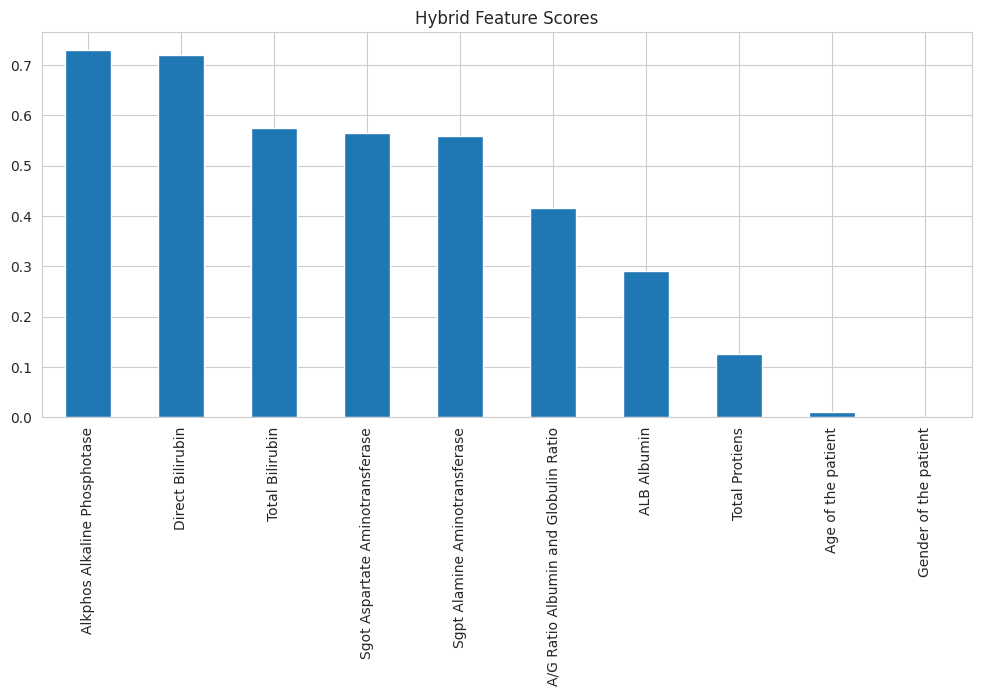

In [ ]:
# Prepare X,y
# The target column is named 'Result', not 'label'.
if 'Result' not in df.columns: raise ValueError('No Result column.')
X = df.drop(columns=['Result']).copy()
y = df['Result'].copy()

# 1. Correlation (abs Pearson)
corr = X.apply(lambda col: col.corr(y)).abs().fillna(0)

# 2. Information Gain (mutual information)
mi = mutual_info_classif(X.fillna(0), y, random_state=42)
mi_s = pd.Series(mi, index=X.columns)

# 3. Gain Ratio (mutual_info / intrinsic value)
def intrinsic_value(col):
    p = pd.Series(col).value_counts(normalize=True)
    return -np.sum(p * np.log2(p + 1e-9))
gr = {}
for c in X.columns:
    try:
        ig = mutual_info_score(X[c].fillna(0), y)
        iv = intrinsic_value(X[c].fillna('NA'))
        gr[c] = ig / (iv + 1e-9)
    except:
        gr[c] = 0
gr_s = pd.Series(gr)

# 4. Chi2 (requires non-negative) — scale features [0,1]
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_nonneg = sc.fit_transform(X.fillna(0))
chi_vals, chi_p = chi2(X_nonneg, y)
chi_s = pd.Series(chi_vals, index=X.columns)

# Combine into DataFrame and normalize 0-1
scores = pd.DataFrame({'corr':corr, 'mi':mi_s, 'gr':gr_s, 'chi':chi_s}).fillna(0)
scores_norm = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
scores_norm['hybrid'] = scores_norm.mean(axis=1)
scores_norm = scores_norm.sort_values('hybrid', ascending=False)
scores_norm.to_csv('hybrid_feature_ranking.csv')
scores_norm.head(30)
# Plot top features
scores_norm['hybrid'].head(25).plot(kind='bar', figsize=(12,5)); plt.title('Hybrid Feature Scores'); plt.show()

Auto-select top-k by CV (fast logistic proxy)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
feat_rank = scores_norm.index.tolist()
max_k = min(20, len(feat_rank))
k_scores={}
skf = StratifiedKFold(5, shuffle=True, random_state=42)
for k in range(3, max_k+1):
    cols = feat_rank[:k]
    Xtmp = df[cols].fillna(df[cols].median())
    clf = Pipeline([('s', StandardScaler()), ('c',LogisticRegression(max_iter=1000, class_weight='balanced'))])
    k_scores[k] = cross_val_score(clf, Xtmp, y, cv=skf, scoring='roc_auc').mean()
best_k = max(k_scores, key=k_scores.get)
print('best_k', best_k, 'score', k_scores[best_k])
# choose features
selected = feat_rank[:best_k]
print('Selected features:', selected)


best_k 8 score 0.7589468595397691
Selected features: ['Alkphos Alkaline Phosphotase', 'Direct Bilirubin', 'Total Bilirubin', 'Sgot Aspartate Aminotransferase', 'Sgpt Alamine Aminotransferase', 'A/G Ratio Albumin and Globulin Ratio', 'ALB Albumin', 'Total Protiens']


Prepare train/val/test and preprocess

In [ ]:
X_use = df[selected].fillna(df[selected].median())
X_train, X_temp, y_train, y_temp = train_test_split(X_use, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

imputer = SimpleImputer(strategy='median'); scaler = StandardScaler()
X_train_p = scaler.fit_transform(imputer.fit_transform(X_train))
X_val_p = scaler.transform(imputer.transform(X_val))
X_test_p = scaler.transform(imputer.transform(X_test))


Train several ML models + small MLP (with graphs)

In [ ]:
# Convert labels from {1,2} to {0,1}
y_train = y_train.replace({1:0, 2:1})
y_test  = y_test.replace({1:0, 2:1})

models = {
    "LR": LogisticRegression(class_weight='balanced', max_iter=1000),
    "RF": RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42),
    "XGB": XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
}

results = {}

for name, m in models.items():
    m.fit(X_train_p, y_train)
    prob = m.predict_proba(X_test_p)[:,1]
    pred = m.predict(X_test_p)

    results[name] = {
        'roc': roc_auc_score(y_test, prob),
        'ap': average_precision_score(y_test, prob),
        'acc': accuracy_score(y_test, pred),
        'model': m
    }

results


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:08:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'LR': {'roc': np.float64(0.757915169096059),
  'ap': np.float64(0.47975831872534785),
  'acc': 0.6372719374456994,
  'model': LogisticRegression(class_weight='balanced', max_iter=1000)},
 'RF': {'roc': np.float64(0.9999746938300091),
  'ap': np.float64(0.9999364271739345),
  'acc': 0.9973935708079931,
  'model': RandomForestClassifier(class_weight='balanced', n_estimators=200,
                         random_state=42)},
 'XGB': {'roc': np.float64(0.9999068640501705),
  'ap': np.float64(0.9997807428550881),
  'acc': 0.9963075586446568,
  'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='logloss',
                feature_types=None, feature_weights=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learni

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9963075586446568
Precision: 0.9984650805832693
Recall: 0.9886018237082067
F1 Score: 0.9935089728904162


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Calculate the metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

# Print the metrics
print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_dt}")

Accuracy: 0.9921807124239791
Precision: 0.987062404870624
Recall: 0.9855623100303952
F1 Score: 0.9863117870722433


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_imputed, y_train)
y_pred_knn = knn_model.predict(X_test_imputed)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Calculate the metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

# Print the metrics
print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")

Accuracy: 0.9845786272806255
Precision: 0.9705215419501134
Recall: 0.9756838905775076
F1 Score: 0.9730958696475938


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Reload original data to ensure 2D input for StandardScaler

X_train, X_test, y_train, y_test = train_test_split( X, y,  test_size=0.2, random_state=42, stratify=y)

# Create a pipeline with imputation, scaling, and logistic regression
model = make_pipeline(
    SimpleImputer(strategy='median'), # Impute missing values
    StandardScaler(),
    LogisticRegression(max_iter=1000) # Increased max_iter
)

# Train the model
model.fit(X_train, y_train)

# Prediction
y_pred_lr = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr}")
print(f"Precision: {precision_lr}")
print(f"Recall: {recall_lr}")
print(f"F1 Score: {f1_lr}")

Accuracy: 0.7268284736927838
Precision: 0.5677083333333334
Recall: 0.18632478632478633
F1 Score: 0.2805662805662806


Adaboast

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.impute import SimpleImputer

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

adaboost_model = AdaBoostClassifier(random_state=42)
adaboost_model.fit(X_train_imputed, y_train)
y_pred_ada = adaboost_model.predict(X_test_imputed)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Calculate the metrics
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)

# Print the metrics
print(f"Accuracy: {accuracy_ada}")
print(f"Precision: {precision_ada}")
print(f"Recall: {recall_ada}")
print(f"F1 Score: {f1_ada}")

Accuracy: 0.7390454471412282
Precision: 0.6791569086651054
Recall: 0.16524216524216523
F1 Score: 0.26581118240146656


Naive Bais

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

nb_model = GaussianNB()
nb_model.fit(X_train_imputed, y_train)
y_pred_nb = nb_model.predict(X_test_imputed)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Calculate the metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb= f1_score(y_test, y_pred_nb)

# Print the metrics
print(f"Accuracy: {accuracy_nb}")
print(f"Precision: {precision_nb}")
print(f"Recall: {recall_nb}")
print(f"F1 Score: {f1_nb}")

Accuracy: 0.5593744909594397
Precision: 0.38932898415657036
Recall: 0.9521367521367521
F1 Score: 0.5526707458243757


Support Vertor Machine



In [ ]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train SVC model on imputed data
svm_model = SVC(random_state=42)
svm_model.fit(X_train_imputed, y_train)
y_pred_svm = svm_model.predict(X_test_imputed)

# Scale the imputed data for LinearSVC
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train LinearSVC model on scaled and imputed data
svm_model_linear = LinearSVC(random_state=42, max_iter=10000) # Increased max_iter for convergence
svm_model_linear.fit(X_train_scaled, y_train)
y_pred_svm_linear = svm_model_linear.predict(X_test_scaled)

# You can choose to evaluate either y_pred_svm or y_pred_svm_linear
# For consistency with the evaluation cell below, let's use y_pred_svm
y_pred_svm = y_pred_svm_linear

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Calculate the metrics
accuracy_svm= accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm= f1_score(y_test, y_pred_svm)

# Print the metrics
print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")
print(f"F1 Score: {f1_svm}")

Accuracy: 0.7198240755823424
Precision: 0.5660377358490566
Recall: 0.08547008547008547
F1 Score: 0.1485148514851485


XGBoost

In [ ]:
from xgboost import XGBClassifier
xgboost_model = XGBClassifier(random_state=42)
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Calculate the metrics
accuracy_xgb= accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb= recall_score(y_test, y_pred_xgb)
f1_xgb= f1_score(y_test, y_pred_xgb)

# Print the metrics
print(f"Accuracy: {accuracy_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1 Score: {f1_xgb}")

Accuracy: 0.9973937123309985
Precision: 0.9977103606182026
Recall: 0.9931623931623932
F1 Score: 0.9954311821816105


ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout # Import Dropout layer
from sklearn.impute import SimpleImputer # Import SimpleImputer
import numpy as np # Import numpy

# Check for NaN and infinite values in X_train and y_train
print("Checking for NaN and infinite values in X_train:")
print(np.isnan(X_train).sum())
print(np.isinf(X_train).sum())
print("Checking for NaN and infinite values in y_train:")
print(np.isnan(y_train).sum())
print(np.isinf(y_train).sum())

# Impute missing values in X_train and X_test
imputer = SimpleImputer(strategy='median') # or 'mean', 'most_frequent'
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


# Define ANN model
ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X_train_imputed.shape[1], activation='relu'))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))

# Compile the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
ann_model.fit(X_train_imputed, y_train, epochs=20, batch_size=32, validation_data=(X_test_imputed, y_test))

# Evaluate the model
ann_predictions = ann_model.predict(X_test_imputed)
# Corrected: Use ann_predictions for evaluation
y_pred_ann = (ann_predictions > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_ann)
precision = precision_score(y_test, y_pred_ann)
recall = recall_score(y_test, y_pred_ann)
f1 = f1_score(y_test, y_pred_ann)

# Output results
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"F1 score: {f1}")

Checking for NaN and infinite values in X_train:
Age of the patient                        2
Gender of the patient                     0
Total Bilirubin                         525
Direct Bilirubin                        460
Alkphos Alkaline Phosphotase            643
Sgpt Alamine Aminotransferase           421
Sgot Aspartate Aminotransferase         365
Total Protiens                          389
ALB Albumin                             396
A/G Ratio Albumin and Globulin Ratio    443
dtype: int64
Age of the patient                      0
Gender of the patient                   0
Total Bilirubin                         0
Direct Bilirubin                        0
Alkphos Alkaline Phosphotase            0
Sgpt Alamine Aminotransferase           0
Sgot Aspartate Aminotransferase         0
Total Protiens                          0
ALB Albumin                             0
A/G Ratio Albumin and Globulin Ratio    0
dtype: int64
Checking for NaN and infinite values in y_train:
0
0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.6473 - loss: 2.8748 - val_accuracy: 0.5770 - val_loss: 0.6376
Epoch 2/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6787 - loss: 0.6398 - val_accuracy: 0.7102 - val_loss: 0.5239
Epoch 3/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6910 - loss: 0.5709 - val_accuracy: 0.7140 - val_loss: 0.5130
Epoch 4/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7044 - loss: 0.5544 - val_accuracy: 0.7035 - val_loss: 0.5093
Epoch 5/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7061 - loss: 0.5283 - val_accuracy: 0.6845 - val_loss: 0.5262
Epoch 6/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7118 - loss: 0.5150 - val_accuracy: 0.7216 - val_loss: 0.4979
Epoch 7/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7127 - loss: 0.5056 - val_accuracy: 0.7218 - val_loss: 0.4882
Epoch 8/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7193 - loss: 0.4987 - val_accuracy

RNN

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from sklearn.model_selection import train_test_split

# Reshape input for RNN if data is 2D
if len(X_train.shape) == 2:
    X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(150, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(150, activation='relu'))
model_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_rnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = model_rnn.predict(X_test)
y_pred_rnn = (y_pred > 0.5).astype("int32")

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred_rnn)
precision = precision_score(y_test, y_pred_rnn)
recall = recall_score(y_test, y_pred_rnn)
f1 = f1_score(y_test, y_pred_rnn)

# Output results
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"F1 score: {f1}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.7111 - loss: nan - val_accuracy: 0.7141 - val_loss: nan
Epoch 2/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7150 - loss: nan - val_accuracy: 0.7141 - val_loss: nan
Epoch 3/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7172 - loss: nan - val_accuracy: 0.7141 - val_loss: nan
Epoch 4/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7130 - loss: nan - val_accuracy: 0.7141 - val_loss: nan
Epoch 5/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7168 - loss: nan - val_accuracy: 0.7141 - val_loss: nan
Epoch 6/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7137 - loss: nan - val_accuracy: 0.7141 - val_loss: nan
Epoch 7/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7160 - loss: nan - val_accuracy: 0.7141 - val_loss: nan
Epoch 8/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7117 - loss: nan - val_accuracy: 0.7141 - val_loss: nan
Epoch 9/20
768/768 ━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30691 entries, 0 to 30690
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age of the patient                    30689 non-null  float64
 1   Gender of the patient                 30691 non-null  int64  
 2   Total Bilirubin                       30043 non-null  float64
 3   Direct Bilirubin                      30130 non-null  float64
 4   Alkphos Alkaline Phosphotase          29895 non-null  float64
 5   Sgpt Alamine Aminotransferase         30153 non-null  float64
 6   Sgot Aspartate Aminotransferase       30229 non-null  float64
 7   Total Protiens                        30228 non-null  float64
 8   ALB Albumin                           30197 non-null  float64
 9   A/G Ratio Albumin and Globulin Ratio  30132 non-null  float64
 10  Result                                30691 non-null  int64  
dtypes: float64(9), 

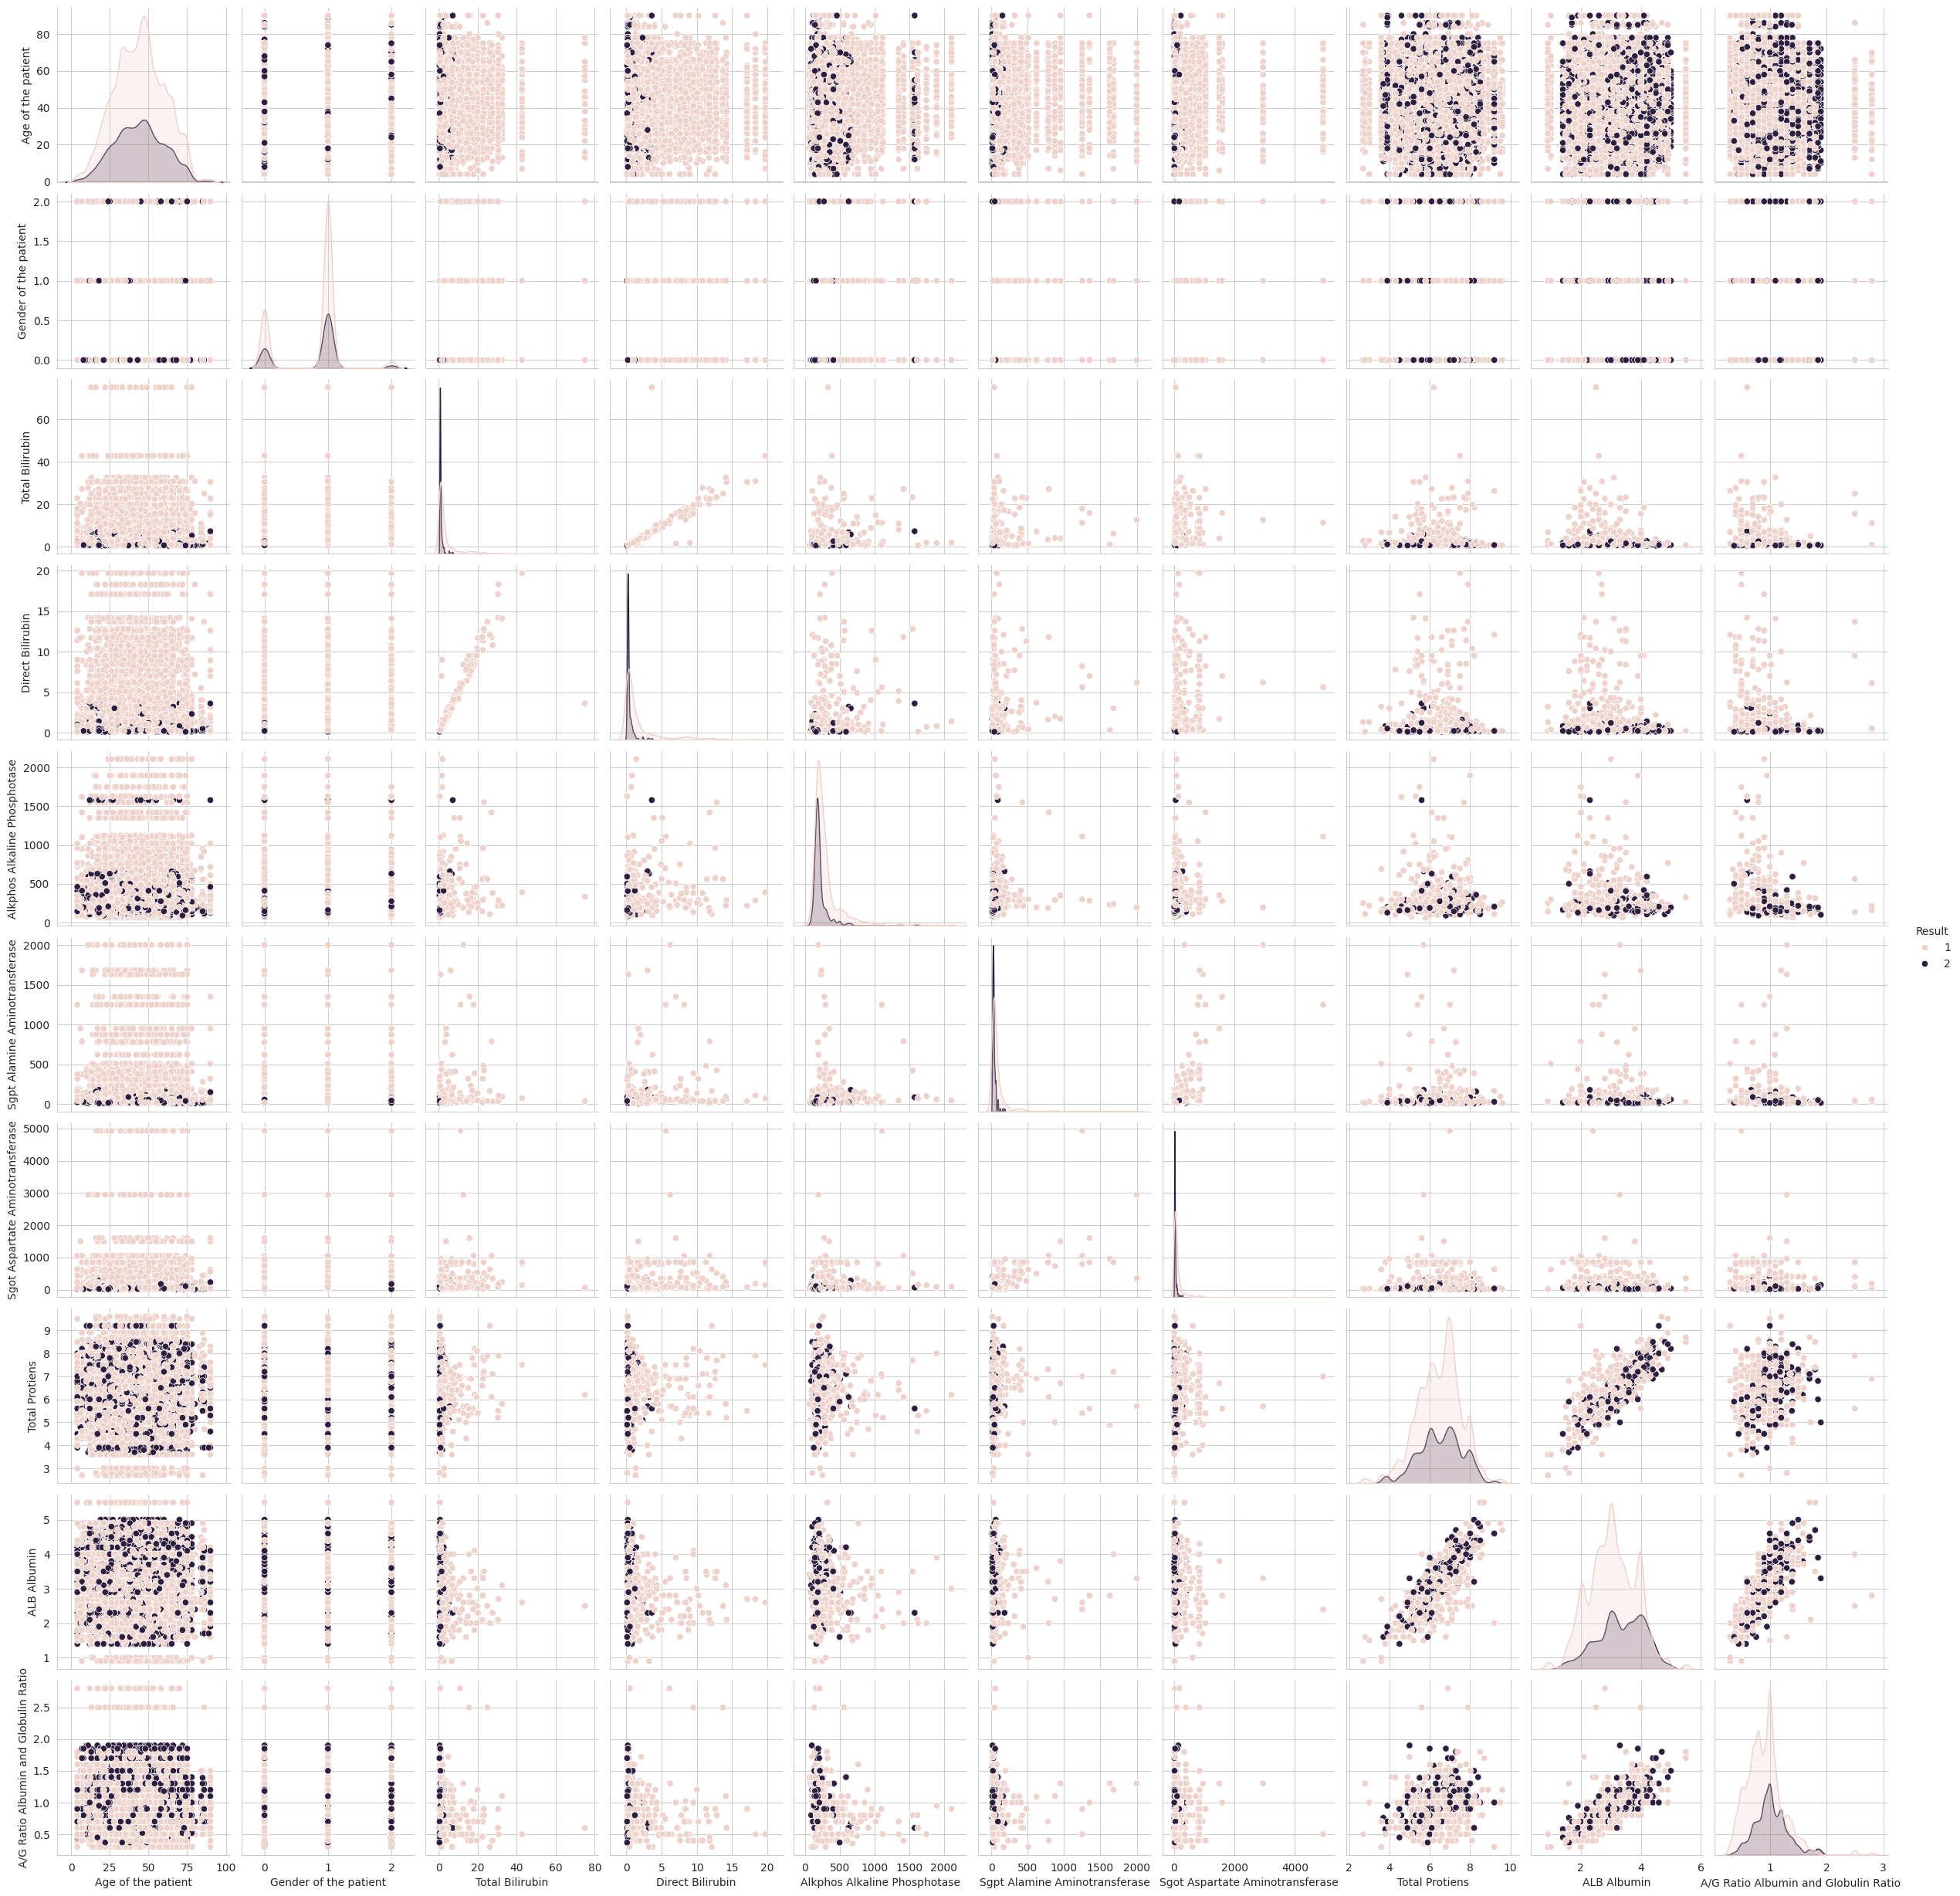

In [ ]:
df.info()
sns.pairplot(df, hue = 'Result')

Hyperparameter tuning with Optuna (XGBoost example) + importance plot

In [ ]:
def xgb_obj(trial):
    params = {
      'n_estimators': trial.suggest_int('n_estimators',50,300),
      'max_depth': trial.suggest_int('max_depth',3,9),
      'learning_rate': trial.suggest_float('learning_rate',0.01,0.2),
      'subsample': trial.suggest_float('subsample',0.6,1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree',0.6,1.0)
    }
    m = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(), **params)
    m.fit(X_train_p, y_train, eval_set=[(X_val_p,y_val)], verbose=False)
    return roc_auc_score(y_val, m.predict_proba(X_val_p)[:,1])

study = optuna.create_study(direction='maximize')
study.optimize(xgb_obj, n_trials=20, show_progress_bar=True)
print('best params', study.best_params)
# train best
xgb_tuned = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(), **study.best_params)
xgb_tuned.fit(X_train_p,y_train)
print('test ROC', roc_auc_score(y_test, xgb_tuned.predict_proba(X_test_p)[:,1]))
# Optuna importance (if plotly present)
try:
    import optuna.visualization as ov; ov.plot_param_importances(study).show()
except Exception as e:
    print('Optuna viz unavailable:', e)


[I 2025-11-18 15:11:00,482] A new study created in memory with name: no-name-b0685261-3e9b-4fa8-aeb5-d8a280bbec41


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:01,591] Trial 0 finished with value: 0.997588171780593 and parameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.1285172697805475, 'subsample': 0.9700129474105258, 'colsample_bytree': 0.9997998748773249}. Best is trial 0 with value: 0.997588171780593.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:13,071] Trial 1 finished with value: 0.9999803559411029 and parameters: {'n_estimators': 249, 'max_depth': 8, 'learning_rate': 0.1331494552179741, 'subsample': 0.7954921728202015, 'colsample_bytree': 0.8784798575643655}. Best is trial 1 with value: 0.9999803559411029.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:16,245] Trial 2 finished with value: 0.9377650792418225 and parameters: {'n_estimators': 141, 'max_depth': 3, 'learning_rate': 0.053804287590009645, 'subsample': 0.7074455246814837, 'colsample_bytree': 0.9739052866740404}. Best is trial 1 with value: 0.9999803559411029.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:23,480] Trial 3 finished with value: 0.9997573380959777 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05716856823432008, 'subsample': 0.621811544913703, 'colsample_bytree': 0.6363849401472986}. Best is trial 1 with value: 0.9999803559411029.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:26,433] Trial 4 finished with value: 0.9981479119058712 and parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.05049863387755275, 'subsample': 0.7093159494692005, 'colsample_bytree': 0.8975646899513221}. Best is trial 1 with value: 0.9999803559411029.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:28,615] Trial 5 finished with value: 0.9999623296282327 and parameters: {'n_estimators': 214, 'max_depth': 5, 'learning_rate': 0.17569924588885488, 'subsample': 0.8598433618947348, 'colsample_bytree': 0.8327244866308214}. Best is trial 1 with value: 0.9999803559411029.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:29,652] Trial 6 finished with value: 0.9999859024989091 and parameters: {'n_estimators': 284, 'max_depth': 8, 'learning_rate': 0.14095824307485544, 'subsample': 0.6248998420938238, 'colsample_bytree': 0.6615663101610666}. Best is trial 6 with value: 0.9999859024989091.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:30,725] Trial 7 finished with value: 0.9999893690975381 and parameters: {'n_estimators': 295, 'max_depth': 8, 'learning_rate': 0.09771067446915445, 'subsample': 0.9439523924360294, 'colsample_bytree': 0.7907463959183026}. Best is trial 7 with value: 0.9999893690975381.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:30,985] Trial 8 finished with value: 0.999829905560609 and parameters: {'n_estimators': 67, 'max_depth': 6, 'learning_rate': 0.1959758843589473, 'subsample': 0.6250303557228987, 'colsample_bytree': 0.9874534419047301}. Best is trial 7 with value: 0.9999893690975381.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:31,694] Trial 9 finished with value: 0.9997094990348989 and parameters: {'n_estimators': 286, 'max_depth': 4, 'learning_rate': 0.11149131525872273, 'subsample': 0.9765877150889923, 'colsample_bytree': 0.7165856800682855}. Best is trial 7 with value: 0.9999893690975381.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:32,705] Trial 10 finished with value: 0.9999870580317854 and parameters: {'n_estimators': 235, 'max_depth': 9, 'learning_rate': 0.08837887423348137, 'subsample': 0.891237954044788, 'colsample_bytree': 0.7430436691897734}. Best is trial 7 with value: 0.9999893690975381.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:33,796] Trial 11 finished with value: 0.9999849780726081 and parameters: {'n_estimators': 240, 'max_depth': 9, 'learning_rate': 0.08581587296231018, 'subsample': 0.8919304448835335, 'colsample_bytree': 0.7501808314653476}. Best is trial 7 with value: 0.9999893690975381.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:38,253] Trial 12 finished with value: 0.9999896002041133 and parameters: {'n_estimators': 294, 'max_depth': 9, 'learning_rate': 0.08850323958835606, 'subsample': 0.9023327227828926, 'colsample_bytree': 0.7883957414848324}. Best is trial 12 with value: 0.9999896002041133.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:39,439] Trial 13 finished with value: 0.9988724310193096 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.014046641592307882, 'subsample': 0.9355369119011226, 'colsample_bytree': 0.7956587538550539}. Best is trial 12 with value: 0.9999896002041133.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:40,411] Trial 14 finished with value: 0.9999558586441254 and parameters: {'n_estimators': 269, 'max_depth': 7, 'learning_rate': 0.08028276597113625, 'subsample': 0.8352615219833011, 'colsample_bytree': 0.803044255360059}. Best is trial 12 with value: 0.9999896002041133.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:41,146] Trial 15 finished with value: 0.9999782759819256 and parameters: {'n_estimators': 194, 'max_depth': 9, 'learning_rate': 0.16275769985430943, 'subsample': 0.9293258524275099, 'colsample_bytree': 0.6871960159801314}. Best is trial 12 with value: 0.9999896002041133.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:41,756] Trial 16 finished with value: 0.9936649065589895 and parameters: {'n_estimators': 169, 'max_depth': 7, 'learning_rate': 0.020305476125556596, 'subsample': 0.9989639747021674, 'colsample_bytree': 0.8666286909585335}. Best is trial 12 with value: 0.9999896002041133.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:42,719] Trial 17 finished with value: 0.999982204793705 and parameters: {'n_estimators': 261, 'max_depth': 7, 'learning_rate': 0.10956456180556264, 'subsample': 0.787250841616864, 'colsample_bytree': 0.7778490563552846}. Best is trial 12 with value: 0.9999896002041133.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:43,808] Trial 18 finished with value: 0.9999655651202863 and parameters: {'n_estimators': 229, 'max_depth': 8, 'learning_rate': 0.06890418128438744, 'subsample': 0.9239958159390048, 'colsample_bytree': 0.9327408476412863}. Best is trial 12 with value: 0.9999896002041133.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-18 15:11:44,156] Trial 19 finished with value: 0.999730067520097 and parameters: {'n_estimators': 51, 'max_depth': 9, 'learning_rate': 0.10263824756451628, 'subsample': 0.8249417480560801, 'colsample_bytree': 0.7028345787678824}. Best is trial 12 with value: 0.9999896002041133.
best params {'n_estimators': 294, 'max_depth': 9, 'learning_rate': 0.08850323958835606, 'subsample': 0.9023327227828926, 'colsample_bytree': 0.7883957414848324}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


test ROC 0.9999722672109689


XAI — SHAP (global & local) and LIME (local) with graphs

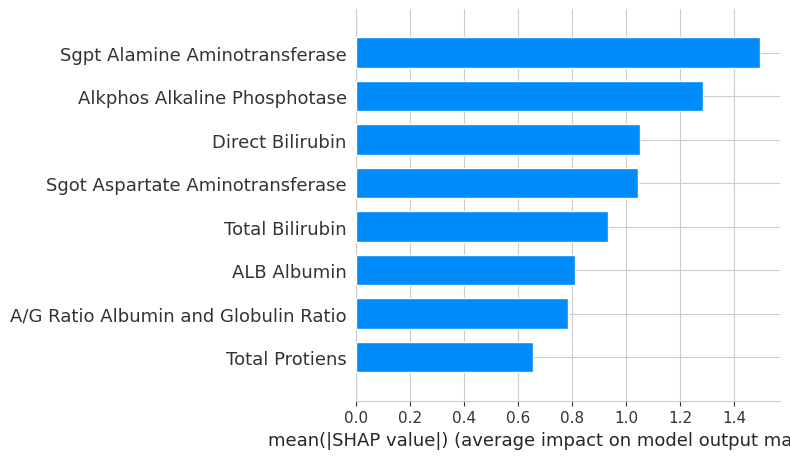

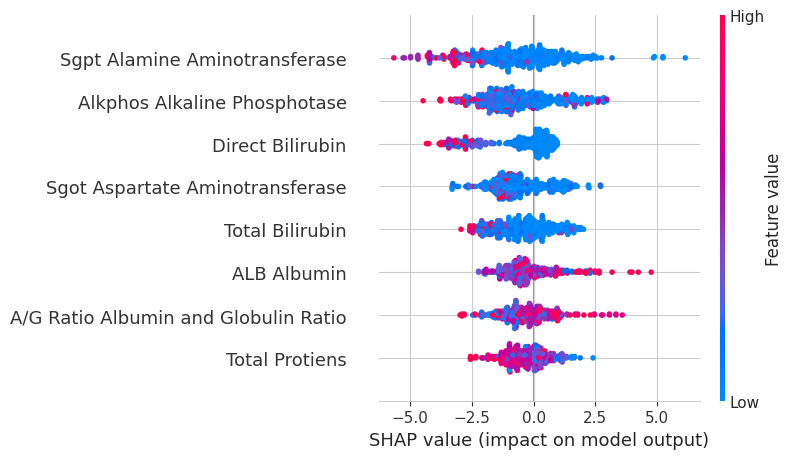

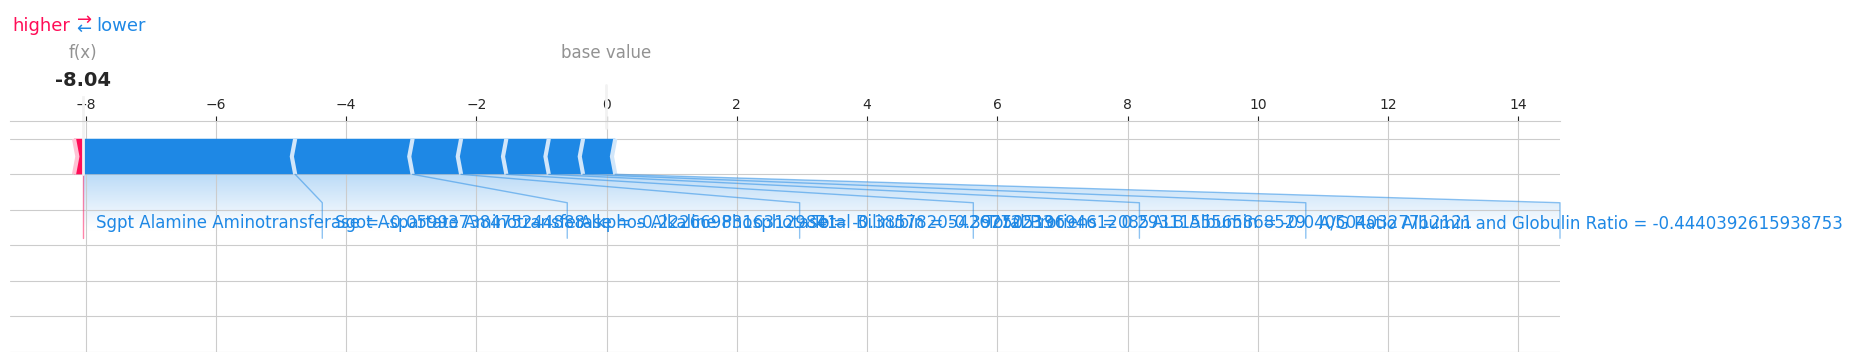

In [ ]:
# SHAP (sample for speed)
explainer = shap.TreeExplainer(xgb_tuned)
idx = np.random.choice(X_test_p.shape[0], min(500, X_test_p.shape[0]), replace=False)
X_shap = pd.DataFrame(X_test_p[idx], columns=selected)
shap_vals = explainer.shap_values(X_shap)

shap.summary_plot(shap_vals, X_shap, plot_type='bar', show=True)
shap.summary_plot(shap_vals, X_shap, show=True)
# Local
shap.force_plot(explainer.expected_value, shap_vals[0,:], X_shap.iloc[0,:], matplotlib=True)

# LIME (for a single instance)
lime_expl = LimeTabularExplainer(training_data=np.array(X_train_p), feature_names=selected, class_names=['No','Yes'], mode='classification')
exp = lime_expl.explain_instance(X_test_p[0], xgb_tuned.predict_proba, num_features=min(8,len(selected)))
exp.show_in_notebook(show_table=True)


Select best model automatically + save full pipeline (imputer+scaler+model)

In [ ]:
# gather candidate results and include xgb_tuned & mlp

# Re-derive y_test to ensure it aligns with X_test_p, as y_test was overwritten globally.
# These variables were first defined in cell KScHhV3TfjiT.
X_use_local = df[selected].fillna(df[selected].median())
_, X_temp_local, _, y_temp_local = train_test_split(X_use_local, y, test_size=0.30, stratify=y, random_state=42)
_, _, _, y_test_local = train_test_split(X_temp_local, y_temp_local, test_size=0.50, stratify=y_temp_local, random_state=42)

results['XGB_tuned']={'model':xgb_tuned,'roc':roc_auc_score(y_test_local,xgb_tuned.predict_proba(X_test_p)[:,1])}
# pick best by ROC
best_name = max(results.items(), key=lambda kv: kv[1]['roc'])[0]
print('Best:',best_name,results[best_name]['roc'])
best_model = results[best_name]['model']
# For sklearn models build pipeline
if best_name!='MLP':
    # Reshape X_train back to 2D if it's 3D (e.g., from RNN preprocessing)
    if len(X_train.shape) == 3:
        X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    else:
        X_train_reshaped = X_train

    full_pipeline = Pipeline([('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler()),('model',best_model)])
    full_pipeline.fit(X_train_reshaped, y_train)
    joblib.dump(full_pipeline,'best_pipeline.pkl')
else:
    # save keras model and build wrapper later
    mlp.save('best_model_keras.h5')
    # still save preprocessing
    joblib.dump({'imputer':SimpleImputer(strategy='median').fit(X_train_reshaped),'scaler':StandardScaler().fit(X_train_reshaped)},'preprocess.pkl')
print('Saved model(s).')

Best: RF 0.9999746938300091
Saved model(s).


SHAP Summary Plot (Feature Importance)

100%|===================| 9198/9208 [10:45<00:00]       

<Figure size 1000x600 with 0 Axes>

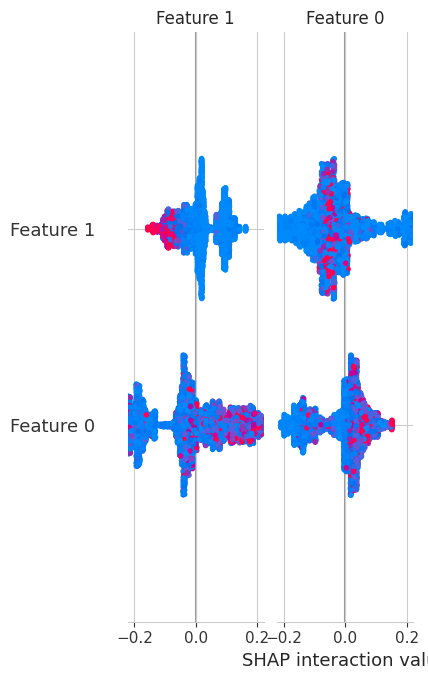

In [ ]:
import shap
import matplotlib.pyplot as plt

# Create SHAP explainer
explainer = shap.Explainer(best_model, X_train_p)
shap_values = explainer(X_test_p)

# Summary Plot
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test_p, plot_type="dot")


SHAP Bar Plot (Mean Abs SHAP Value)

<Figure size 1000x600 with 0 Axes>

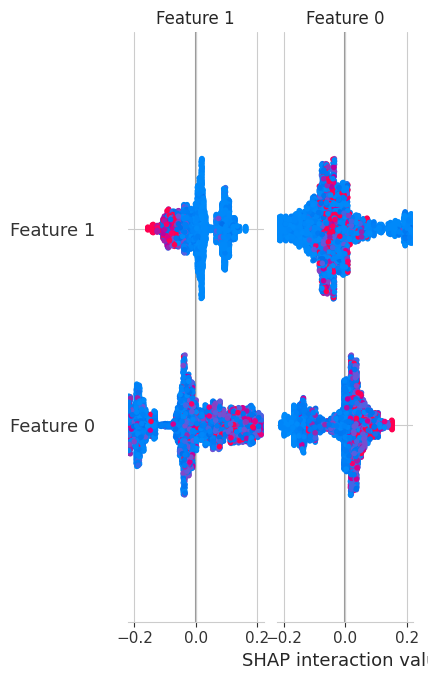

In [ ]:
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test_p, plot_type="bar")


SHAP Waterfall Plot for a Single Instance

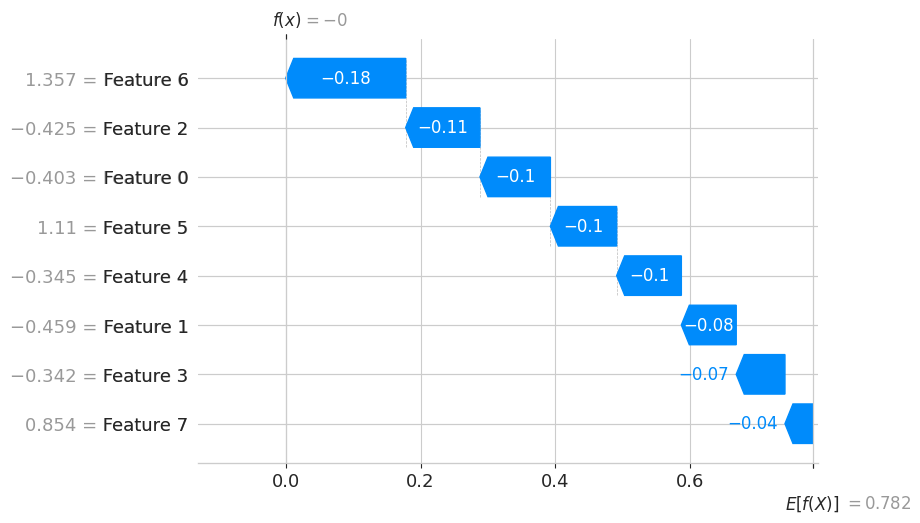

In [ ]:
idx = 0
shap.plots.waterfall(shap_values[idx, :, 0])

. LIME Plot (Local Explanation for One Patient)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Build explainer
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train_p),
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'],
    mode='classification'
)

# Pick one example to explain
sample_idx = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_p[sample_idx],
    predict_fn=best_model.predict_proba
)

# Show LIME Graph (HTML window opens in Colab)
exp.show_in_notebook(show_table=True)

Save LIME Plot as Image (PNG)

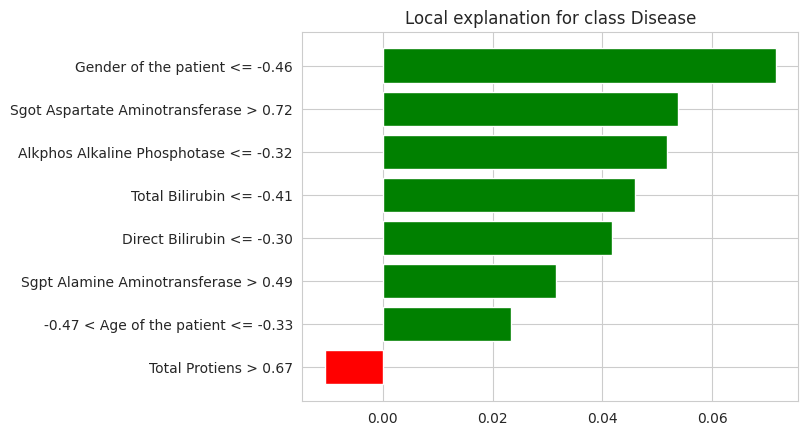

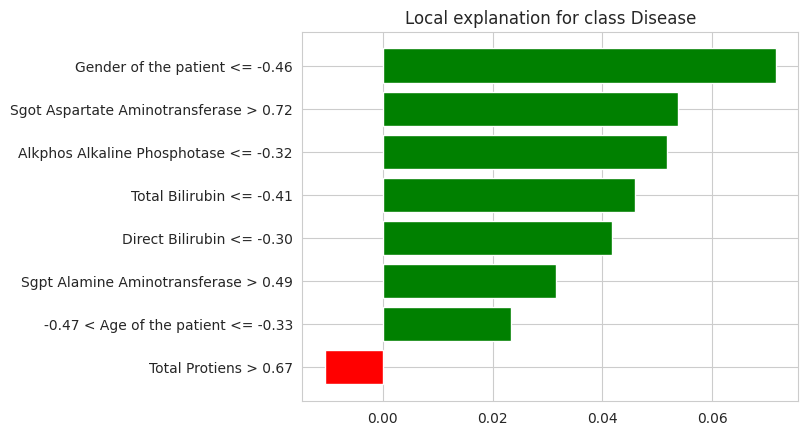

In [ ]:
fig = exp.as_pyplot_figure()
fig.savefig("lime_explanation.png", dpi=300, bbox_inches='tight')
fig


Deployment scaffolds (FastAPI, Streamlit, Dockerfile)

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib, pandas as pd

app = FastAPI()
model = joblib.load('best_pipeline.pkl')  # ensure exists

class Patient(BaseModel):
    features: dict

@app.post('/predict')
def predict(item: Patient):
    df = pd.DataFrame([item.features])
    prob = model.predict_proba(df)[:,1]
    return {'disease_probability': float(prob[0])}
